<a href="https://colab.research.google.com/github/rvidals/automatizacao-mapas-coropleticos-cobertura-vacinal-covid19/blob/main/Automatizacao_Mapas_Cobertura_Vacinal_CME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install pysal
!pip install mapclassify
!pip install matplotlib_scalebar

In [ ]:
import os
import seaborn
import pandas as pd
import numpy as np
import geopandas as gpd
import pysal
import numpy
from google.colab import files
import mapclassify
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.legend_handler import HandlerPatch
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
#Upload da tabela
uploaded = files.upload()
file = uploaded.keys()
path_excel = "/content/" + list(file)[0]

Saving cme.xlsx to cme.xlsx


In [ ]:
#Upload do shp
#Importante pegar todos os arquivos
uploaded = files.upload()
file = uploaded.keys()
path_shp = "/content/" + list(file)[0]

Saving BR_UF_2020.cpg to BR_UF_2020.cpg
Saving BR_UF_2020.dbf to BR_UF_2020.dbf
Saving BR_UF_2020.prj to BR_UF_2020.prj
Saving BR_UF_2020.shp to BR_UF_2020.shp
Saving BR_UF_2020.shx to BR_UF_2020.shx


In [ ]:
#Função que lê o excel e transforma em dataframe
def excel_to_df(path: str):
  df = pd.read_excel(path,
                     skipfooter=3)#Parâmetro para limpar linha do excel
  df = df.sort_values(list(df.columns)).reset_index(drop=True)
  df = df.rename(columns={'Unidade  Federada':'NM_UF'}) #Renomemando coluna 
  return df

In [ ]:
#Função que lê o shp e transforma em geodataframe
def shp_to_gdf(path: str):
  #Separa o nome do arquivo e a extensão
  nm, ext = os.path.splitext(path_shp)
  gdf = gpd.read_file(nm+'.shp')
  gdf = gdf.sort_values(by=["NM_UF"]).reset_index(drop=True)
  return gdf

In [ ]:
def join_df_to_shp(gdf, df):
  #Criando o merge entre os df's
  df = pd.merge(gdf, #GeoDataFrame
                df, #DataFrame
                on="NM_UF", #Coluna com chaves
                how="left" #Mode de junção
              );
  
  crs = 'EPSG:4674' #Setando o sistema de projeção

  #Criando um GeoDataFrame
  gdf = gpd.GeoDataFrame(df, #Merge criado
                         crs=crs, #Setando o sistema de projeção
                         geometry='geometry' # Setando a geometria
                        );
  return gdf


In [ ]:
def ordenar_colunas(gdf):
  #Função para ordenar as colunas
  gdf = gdf[['CD_UF',
            'NM_UF',
            'SIGLA_UF',
            'NM_REGIAO',
            'LEGENDA',
            '03 a 04 anos (D1)',
            ' 05 a 11 anos (D2)',
            '12 a 17 anos (D2)',
            '12 a 17 anos (REF1)',
            '18 a 39 anos (D2)',
            '18 a 39 anos (REF1)',
            '40 anos e + (D2)',
            '40 anos e + (REF1)',
            '40 anos e + (REF2)',
            'geometry']]
  return gdf

In [ ]:
def criar_mapas(gdf):

    #Verificador se o tipo da coluna é float
    #Estrutura de loop para fazer os mapas por coluna
    for n, t in zip(gdf, list(gdf.dtypes)):
      if t == float:

        #Classificação de acordo com o estabelecido
        #0 - 30 = <30%
        #30 - 50 = 30% - 50%
        #50 - 90 = 50% - 90%
        #90 - 100 = >=90%
        classi = pd.cut(
        gdf[n], [0, 30, 50, 90, 100]
        )

        
        if classi.name == '03 a 04 anos (D1)':
          titulo = '1º Dose - 03 a 04 anos'
        elif classi.name == ' 05 a 11 anos (D2)':
          titulo = '2º Dose - 05 a 11 anos'
        elif classi.name =='12 a 17 anos (D2)':
          titulo = '2º Dose - 12 a 17 anos'
        elif classi.name =='12 a 17 anos (REF1)':
          titulo = '1º Dose de Reforço - 12 a 17 anos'
        elif classi.name =='18 a 39 anos (D2)':
          titulo = '2º Dose - 18 a 39 anos'
        elif classi.name =='18 a 39 anos (REF1)':
          titulo = '1º Dose de Reforço - 18 a 39 anos'
        elif classi.name =='40 anos e + (D2)':
          titulo = '2º Dose - 40 anos e mais'
        elif classi.name =='40 anos e + (REF1)':
          titulo = '1º Dose de Reforço - 40 anos e mais'
        elif classi.name =='40 anos e + (REF2)':
          titulo = '2º Dose de Reforço - 40 anos e mais'
 
        #Variáveis para criar a legenda
        leg_args = {'loc': 'lower left',
            'prop': {'size': 15},
            'title_fontsize':15,
            'markerscale':2,
            'title':f"{'Cobertura Vacinal': ^10}\n{titulo: ^10}", #Título legenda
            'frameon': False}


        #Criação da escala
        scale1 = ScaleBar(
            dx=1,
            units="km",
            dimension="si-length",
            length_fraction=0.25,
            scale_formatter = lambda value, unit: f"{value * 10} {unit}",
            location='lower right'
        )


        #Plotando os gráficos e atribuindo-os à variável ax1
        ax1 = gdf.plot(
            classi,
            legend_kwds=leg_args,
            legend=True,
            cmap='Blues',
            edgecolor="k",
            linewidth=0.2,
            figsize=(30,15)
        )

        #Renomenado os labols das legendas 
        leg = ax1.get_legend()
        leg.get_texts()[0].set_text('<30%')
        leg.get_texts()[1].set_text('30% - 49.9%')
        leg.get_texts()[2].set_text('50% - 89.9%')
        leg.get_texts()[3].set_text('≥90%')

        #Label dos estados. Foi utilizado o centroid de cada geometria
        texts = [ax1.text(row['geometry'].centroid.x, row['geometry'].centroid.y, s=row["SIGLA_UF"], horizontalalignment='center') for idx, row in gdf.iterrows()]

        #Remoção da grade de coordenadas
        ax1.set_axis_off()

        #Organizando os elementos no plt
        # plt.tight_layout()

        #Adicionando a escala
        ax1.add_artist(scale1)

        #Criação do Norte e adicionando na coordenada long: -32.88, lat: 3.78
        ax1.text(-32.88, 3.78,u'\u25B2 \nN ', ha='center', fontsize=30, family='Arial')

        plt.savefig(n)



In [ ]:
df = excel_to_df(path_excel)
df.head()

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,NM_UF,03 a 04 anos (D1),05 a 11 anos (D2),12 a 17 anos (D2),12 a 17 anos (REF1),18 a 39 anos (D2),18 a 39 anos (REF1),40 anos e + (D2),40 anos e + (REF1),40 anos e + (REF2)
0,Acre,11.293398,28.453689,65.784140,14.537952,76.840893,37.257401,91.288917,59.216436,25.285407
1,Alagoas,17.025501,40.076274,72.463233,19.259852,79.103205,39.548718,90.898444,63.786285,29.397556
2,Amapá,23.529412,34.342856,61.517804,17.483241,64.382865,31.068029,79.994517,49.710707,22.594379
3,Amazonas,21.073745,37.046018,68.344895,12.633038,74.974894,19.417086,86.136457,34.490501,11.837169
4,Bahia,20.625690,47.140378,73.878099,28.255852,84.249343,49.731875,92.619120,71.191608,39.368737


In [ ]:
gdf = shp_to_gdf(path_shp)
gdf.head()

,CD_UF,NM_UF,SIGLA_UF,NM_REGIAO,LEGENDA,geometry
0,12,Acre,AC,Norte,Acre,"POLYGON ((-71.07772 -9.82774, -71.07817 -9.828..."
1,27,Alagoas,AL,Nordeste,Alagoas,"MULTIPOLYGON (((-35.75791 -9.69285, -35.75801 ..."
2,16,Amapá,AP,Norte,Amapá,"MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2..."
3,13,Amazonas,AM,Norte,Amazonas,"POLYGON ((-69.83766 -3.68659, -69.82555 -3.620..."
4,29,Bahia,BA,Nordeste,Bahia,"MULTIPOLYGON (((-38.69616 -17.97901, -38.69618..."


In [ ]:
merge = join_df_to_shp(gdf, df)
merge_ordenado = ordenar_colunas(merge)
merge_ordenado

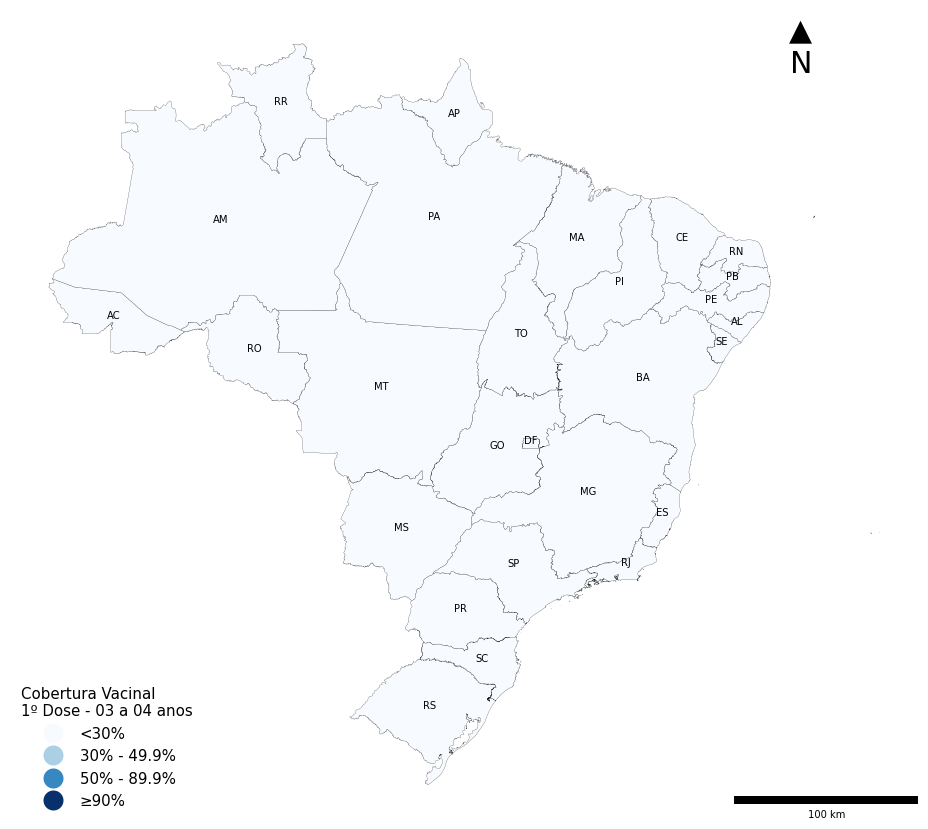

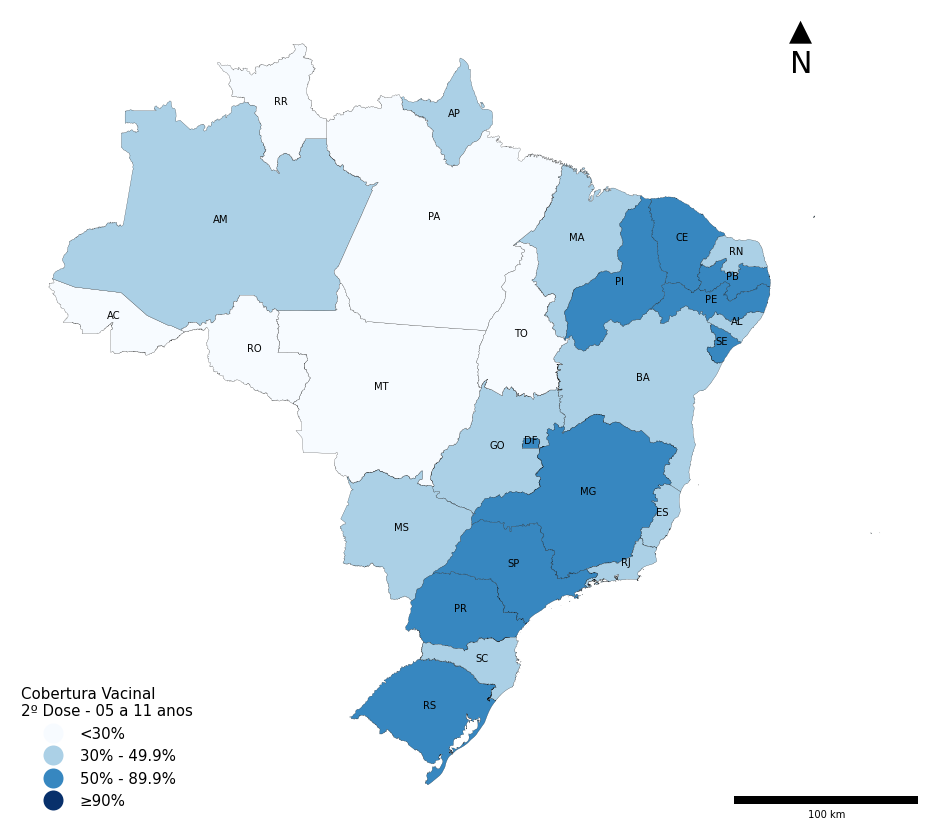

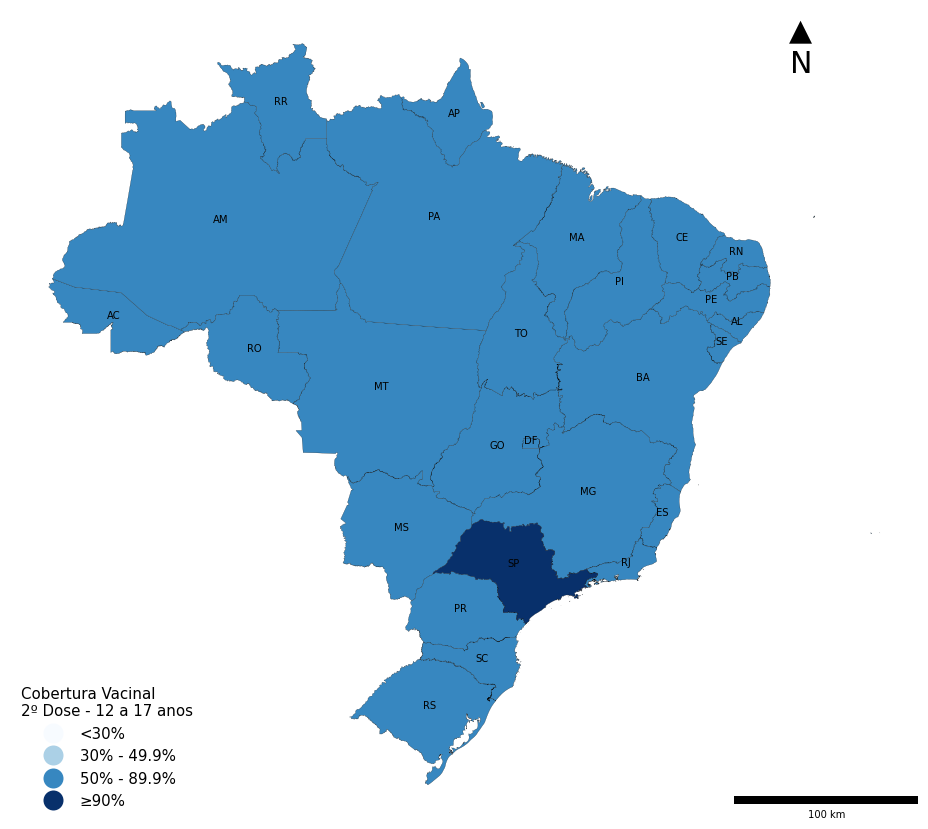

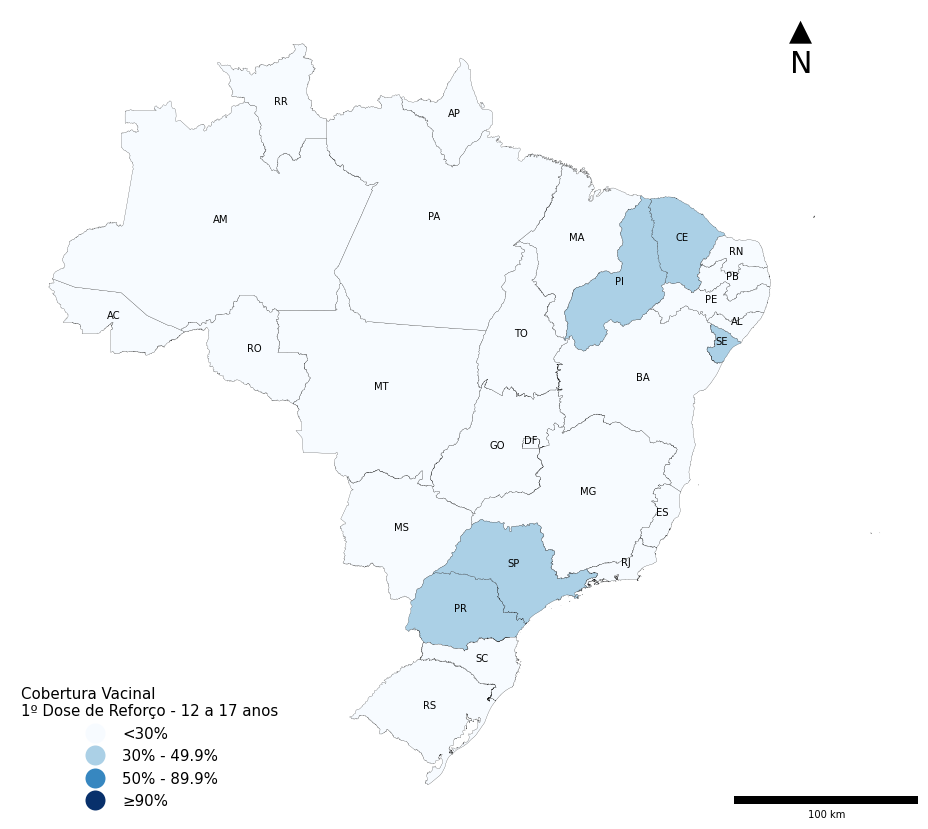

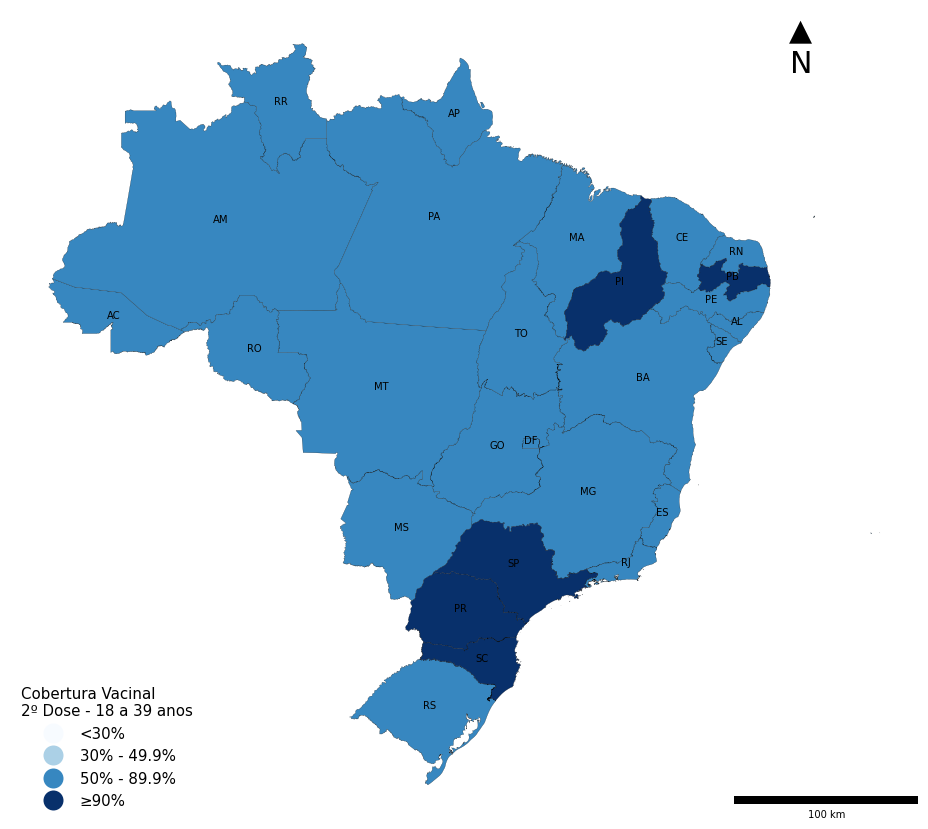

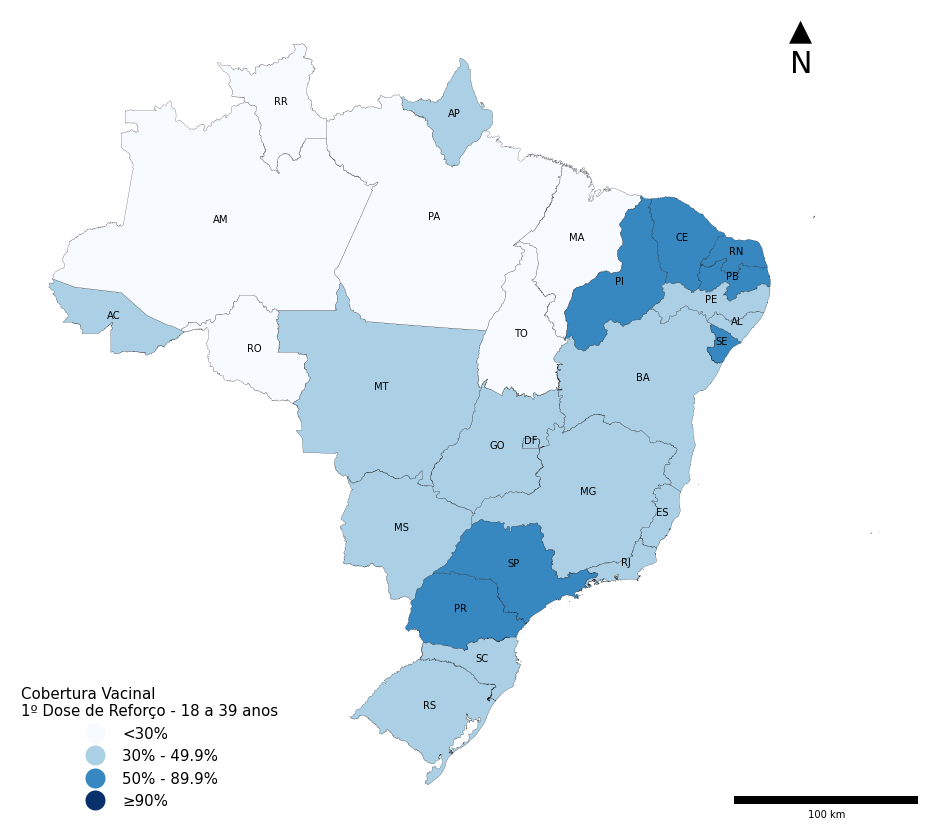

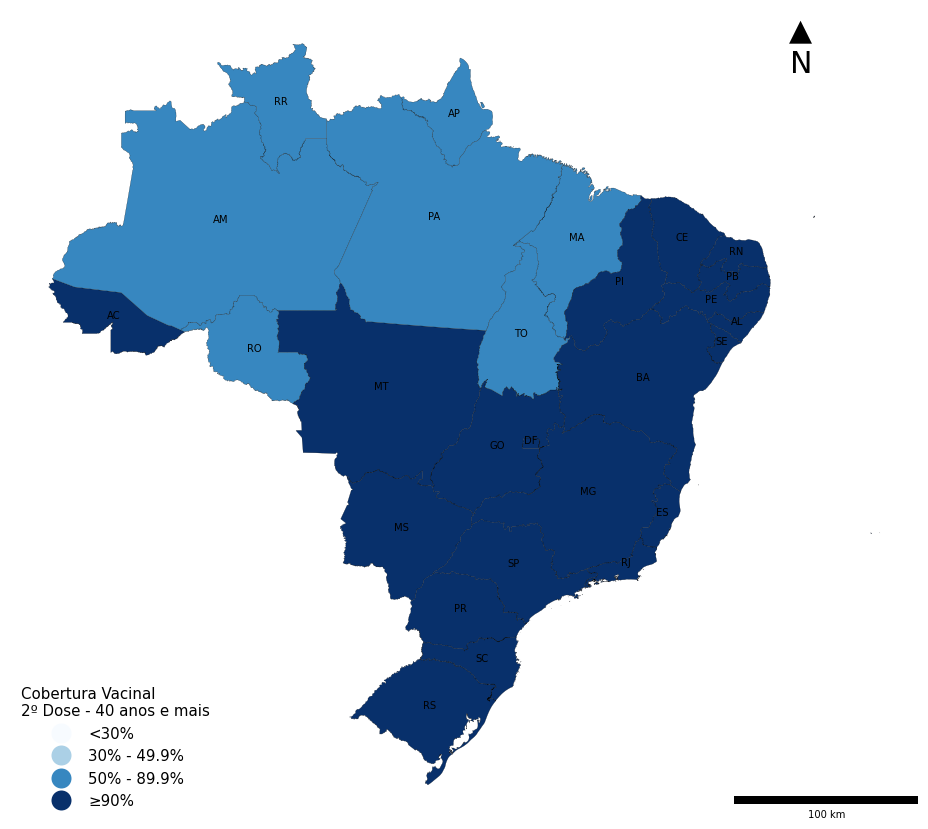

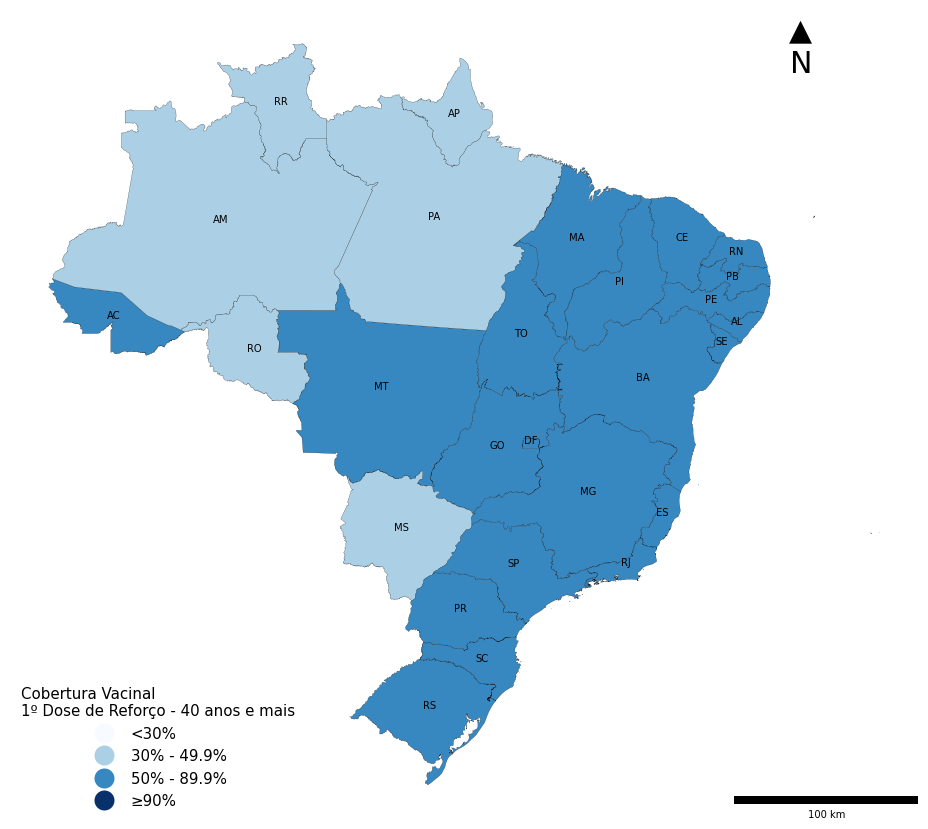

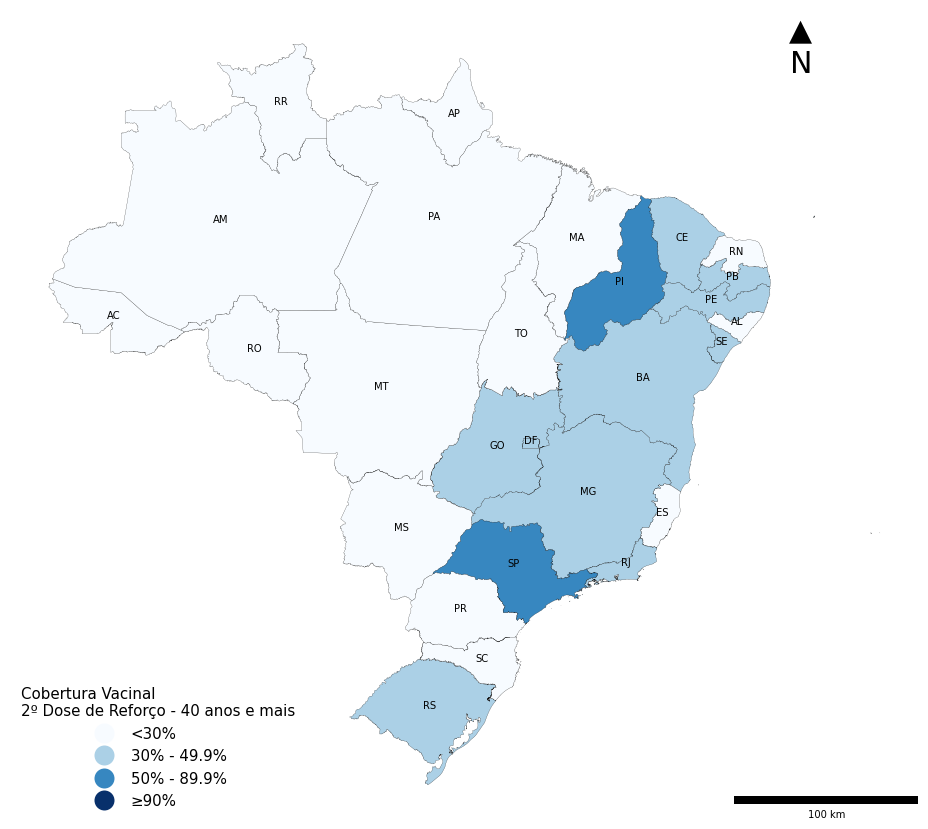

In [ ]:
criar_mapas(merge_ordenado)

In [ ]:
!rm *.png